In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm

%matplotlib inline

import sklearn as sk

In [337]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

### Data summary function for continuous variables,

In [340]:
def continuous_var_sum(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

### Data summary function for categorical variables,

In [341]:
def categorical_var_sum(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

### Missing value imputation for continuous and categorical variables,

In [342]:
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [343]:
cust_data = pd.read_excel('Data Set.xlsx')
cust_data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [344]:
cust_data.shape

(5000, 130)

### Data preparation and cleaning

In [345]:
cust_data.drop(columns = ['custid','birthmonth'], inplace=True)

In [346]:
cust_data.columns

Index(['region', 'townsize', 'gender', 'age', 'agecat', 'ed', 'edcat',
       'jobcat', 'union', 'employ',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=128)

In [347]:
for x in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    cust_data[x] = cust_data[x].astype('object')

In [353]:
num_vars = cust_data.select_dtypes(['float64','int64', 'int32', 'float64'])
cat_vars = cust_data.select_dtypes('object')

In [354]:
num_vars.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,2.0,20,2,15,3,0,1,31,3.433987,...,0,0,0,1,1,0,0,0,1,0
1,5,5.0,22,2,17,4,0,1,15,2.708050,...,1,1,1,1,1,1,1,0,0,0
2,3,4.0,67,6,14,2,16,5,35,3.555348,...,1,0,0,0,0,0,1,0,0,0
3,4,3.0,23,2,16,3,0,1,20,2.995732,...,1,0,1,1,1,0,1,1,0,0
4,2,2.0,26,3,16,3,1,1,23,3.135494,...,1,0,1,0,1,0,0,0,1,0


In [355]:
cat_vars.head()

,gender,jobcat,union,retire,default,marital,homeown,hometype,carown,cartype,...,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenurecat,bfast,internet
0,1,1,1,0,1,0,0,2,1,0,...,1,0,2,5,3,1,0,2,3,0
1,0,2,0,0,1,0,1,3,1,1,...,1,0,2,4,1,3,0,2,1,4
2,1,2,0,0,0,1,1,1,1,1,...,4,0,5,4,1,3,0,5,3,0
3,0,2,0,0,1,1,1,3,1,1,...,4,0,2,3,2,4,0,2,1,2
4,0,2,0,0,0,1,0,2,0,1,...,1,0,3,1,3,2,0,3,3,3


In [356]:
num_vars.apply(continuous_var_summary).T.round(1).sort_values('NMISS',ascending=False).head(10)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
lnwiremon,1344.0,3656.0,4845.1,3.6,3.6,0.4,0.2,2.5,2.8,3.0,3.1,3.3,3.6,3.9,4.1,4.3,4.6,5.2
lnwireten,1344.0,3656.0,9150.1,6.8,7.1,1.3,1.6,2.5,3.0,4.1,4.9,6.2,7.1,7.8,8.1,8.3,8.7,9.5
lnequipten,1704.0,3296.0,11497.4,6.7,7.1,1.2,1.4,2.5,3.2,4.3,5.0,6.2,7.1,7.6,8.0,8.1,8.4,8.8
lnequipmon,1704.0,3296.0,6134.8,3.6,3.6,0.3,0.1,2.8,3.0,3.1,3.2,3.4,3.6,3.8,4.0,4.1,4.3,4.7
lntollten,2378.0,2622.0,15658.6,6.6,6.9,1.2,1.5,2.2,2.8,4.2,4.8,5.9,6.9,7.5,7.9,8.1,8.4,8.8
lntollmon,2378.0,2622.0,7712.4,3.2,3.2,0.4,0.2,2.1,2.3,2.6,2.7,3.0,3.2,3.5,3.8,3.9,4.2,4.6
lncardten,3578.0,1422.0,22993.3,6.4,6.6,1.2,1.4,1.6,2.5,4.1,4.9,5.9,6.6,7.2,7.7,7.9,8.4,9.5
lncardmon,3581.0,1419.0,10419.8,2.9,2.9,0.6,0.3,1.2,1.7,2.0,2.2,2.5,2.9,3.3,3.6,3.8,4.2,5.2
lnlongten,4997.0,3.0,28039.7,5.6,5.9,1.6,2.7,-0.1,0.9,2.5,3.3,4.7,5.9,6.8,7.5,7.9,8.5,9.5
longten,4997.0,3.0,3542232.2,708.9,350.0,979.3,959011.0,0.9,2.4,12.6,28.3,104.6,350.0,913.8,1808.8,2567.6,4689.1,13046.5


### Dropping variables that have missing values more than 25%

In [357]:
num_vars.drop(columns=['lnwiremon','lnwireten','lnequipten','lnequipmon','lntollten','lntollmon','lncardten','lncardmon'],inplace=True)

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [358]:
cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
gender,5000.0,0.0,1.0,2518.0,50.36
jobcat,5000.0,0.0,2.0,1640.0,32.80
union,5000.0,0.0,0.0,4244.0,84.88
retire,5000.0,0.0,0.0,4262.0,85.24
default,5000.0,0.0,0.0,3829.0,76.58
marital,5000.0,0.0,0.0,2599.0,51.98
homeown,5000.0,0.0,1.0,3148.0,62.96
hometype,5000.0,0.0,1.0,2265.0,45.30
carown,5000.0,0.0,1.0,3704.0,74.08
cartype,5000.0,0.0,0.0,2287.0,45.74


### Performing outlier treatment by capping of variables

In [360]:
num_vars = num_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [362]:
num_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,5000.0,0.0,15007.0,3.001400,3.0,1.421760,2.021402,1.0,1.0,1.0,1.0,2.0,3.0,4.0,5.0,5.0,5.0,5.0
townsize,4998.0,2.0,13431.0,2.687275,3.0,1.425925,2.033262,1.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,5.0,5.0,5.0
age,5000.0,0.0,235128.0,47.025600,47.0,17.770338,315.784902,18.0,18.0,20.0,23.0,31.0,47.0,62.0,72.0,76.0,79.0,79.0
agecat,5000.0,0.0,21194.0,4.238800,4.0,1.308785,1.712917,2.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,6.0,6.0,6.0
ed,5000.0,0.0,72721.0,14.544200,14.0,3.242553,10.514149,8.0,8.0,9.0,10.0,12.0,14.0,17.0,19.0,20.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ownfax,5000.0,0.0,894.0,0.178800,0.0,0.383223,0.146860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
news,5000.0,0.0,2363.0,0.472600,0.0,0.499299,0.249299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
response_01,5000.0,0.0,418.0,0.083600,0.0,0.276815,0.076626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
response_02,5000.0,0.0,649.0,0.129800,0.0,0.336117,0.112975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


### Missing value imputations

In [364]:
num_vars = num_vars.apply(missing_imputation)
cat_vars = cat_vars.apply(missing_imputation)

In [366]:
num_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,5000.0,0.0,15007.00000,3.001400,3.0,1.421760,2.021402,1.0,1.0,1.0,1.0,2.0,3.0,4.0,5.0,5.0,5.0,5.0
townsize,5000.0,0.0,13436.37455,2.687275,3.0,1.425640,2.032449,1.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,5.0,5.0,5.0
age,5000.0,0.0,235128.00000,47.025600,47.0,17.770338,315.784902,18.0,18.0,20.0,23.0,31.0,47.0,62.0,72.0,76.0,79.0,79.0
agecat,5000.0,0.0,21194.00000,4.238800,4.0,1.308785,1.712917,2.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,6.0,6.0,6.0
ed,5000.0,0.0,72721.00000,14.544200,14.0,3.242553,10.514149,8.0,8.0,9.0,10.0,12.0,14.0,17.0,19.0,20.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ownfax,5000.0,0.0,894.00000,0.178800,0.0,0.383223,0.146860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
news,5000.0,0.0,2363.00000,0.472600,0.0,0.499299,0.249299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
response_01,5000.0,0.0,418.00000,0.083600,0.0,0.276815,0.076626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
response_02,5000.0,0.0,649.00000,0.129800,0.0,0.336117,0.112975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [367]:
cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
gender,5000.0,0.0,1.0,2518.0,50.36
jobcat,5000.0,0.0,2.0,1640.0,32.80
union,5000.0,0.0,0.0,4244.0,84.88
retire,5000.0,0.0,0.0,4262.0,85.24
default,5000.0,0.0,0.0,3829.0,76.58
marital,5000.0,0.0,0.0,2599.0,51.98
homeown,5000.0,0.0,1.0,3148.0,62.96
hometype,5000.0,0.0,1.0,2265.0,45.30
carown,5000.0,0.0,1.0,3704.0,74.08
cartype,5000.0,0.0,0.0,2287.0,45.74


### Dummy variables creation

In [368]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [369]:
cat_vars = cust_data[['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']]

for cat_feature in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    cat_vars[cat_feature] = cat_vars[cat_feature].astype('category')
    cat_vars = create_dummies(cat_vars, cat_feature)
 

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [370]:
cat_vars.head()

,gender_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,retire_1,default_1,marital_1,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0


### Merging the two datasets (continuous and categorical)

In [371]:
cust_data_new = pd.concat([num_vars, cat_vars], axis = 1)
cust_data_new.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,2.0,20,2,15,3,0,1,31.0,3.433987,...,1,0,0,0,0,1,0,0,0,0
1,5,5.0,22,2,17,4,0,1,15.0,2.708050,...,1,0,0,0,0,0,0,0,0,1
2,3,4.0,67,6,14,2,16,5,35.0,3.555348,...,0,0,0,1,0,1,0,0,0,0
3,4,3.0,23,2,16,3,0,1,20.0,2.995732,...,1,0,0,0,0,0,0,1,0,0
4,2,2.0,26,3,16,3,1,1,23.0,3.135494,...,0,1,0,0,0,1,0,0,1,0


In [372]:
cust_data_new['total_spent'] = cust_data_new['cardspent'] + cust_data_new['card2spent']
cust_data_new.drop(columns = ['cardspent','card2spent'],inplace=True)

In [373]:
cust_data_new['total_spent'].head()

0    149.46
1     77.54
2    359.97
3    359.41
4    507.83
Name: total_spent, dtype: float64

### Checking if the dependent variable is normally distributed

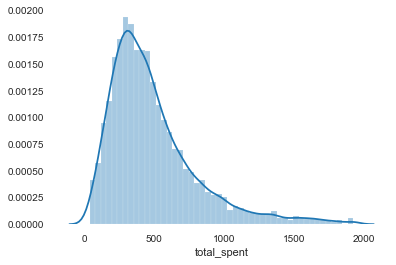

In [375]:
sns.distplot(cust_data_new['total_spent'])
plt.show()

###### Since the data is skewed to the right, we use log transformation to make it a normal distribution.

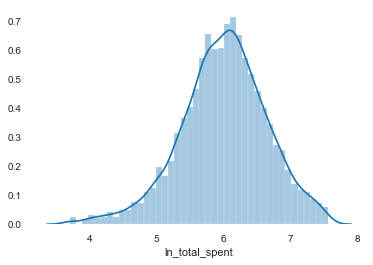

In [376]:
cust_data_new['ln_total_spent'] = np.log(cust_data_new['total_spent'])
sns.distplot(cust_data_new['ln_total_spent'])
plt.show()

In [377]:
corr_matrix = cust_data.corr()
corr_matrix

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
region,1.000000,0.414194,-0.026525,-0.018455,0.013173,0.015710,-0.011036,-0.009345,0.044823,0.042995,...,0.048589,0.040228,0.020596,0.007504,0.026391,0.036622,0.012312,-0.013004,0.005899,0.005694
townsize,0.414194,1.000000,-0.075464,-0.069081,0.002531,0.003685,-0.059014,-0.058169,-0.001915,0.001580,...,0.020692,0.022758,0.002664,0.005331,0.007896,-0.000636,-0.028678,-0.006225,-0.010037,-0.007200
age,-0.026525,-0.075464,1.000000,0.969879,-0.094560,-0.081129,0.703053,0.739573,0.189301,0.144156,...,0.055100,-0.074423,-0.133284,-0.217524,-0.235226,-0.042090,0.365204,0.015140,0.013175,-0.026231
agecat,-0.018455,-0.069081,0.969879,1.000000,-0.079021,-0.064124,0.676722,0.732246,0.211927,0.190952,...,0.078888,-0.059490,-0.123192,-0.208690,-0.223387,-0.029310,0.348275,0.010039,0.010467,-0.014860
ed,0.013173,0.002531,-0.094560,-0.079021,1.000000,0.963896,-0.215374,-0.197884,0.178036,0.208098,...,0.053189,0.299871,0.435034,0.369256,0.376235,0.276750,-0.073644,-0.117606,0.073207,0.107171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ownfax,0.036622,-0.000636,-0.042090,-0.029310,0.276750,0.273646,-0.040181,-0.035826,0.145425,0.148100,...,0.050193,0.434104,0.243924,0.237789,0.230499,1.000000,-0.024573,-0.014592,0.032549,0.093360
news,0.012312,-0.028678,0.365204,0.348275,-0.073644,-0.068420,0.367161,0.369206,0.121696,0.107830,...,0.119674,-0.037949,-0.061753,-0.099716,-0.089811,-0.024573,1.000000,0.020919,0.030136,-0.011148
response_01,-0.013004,-0.006225,0.015140,0.010039,-0.117606,-0.112653,0.040096,0.030418,-0.007106,-0.002061,...,-0.002627,-0.023472,-0.107194,-0.069870,-0.096176,-0.014592,0.020919,1.000000,-0.015601,-0.018781
response_02,0.005899,-0.010037,0.013175,0.010467,0.073207,0.070172,0.014430,0.017504,0.053693,0.060972,...,0.015718,0.021608,0.039891,0.015485,0.011744,0.032549,0.030136,-0.015601,1.000000,0.028266


### Splitting the data into training and testing datasets

In [378]:
train,test=train_test_split(cust_data_new,test_size=0.3,random_state=56789)

In [379]:
train.shape

(3500, 166)

In [380]:
test.shape

(1500, 166)

In [381]:
train.columns= [phrase.strip().replace('-', '') for phrase in train.columns]
train.columns

Index(['region', 'townsize', 'age', 'agecat', 'ed', 'edcat', 'employ',
       'empcat', 'income', 'lninc',
       ...
       'card2tenurecat_4', 'card2tenurecat_5', 'bfast_2', 'bfast_3',
       'internet_1', 'internet_2', 'internet_3', 'internet_4', 'total_spent',
       'ln_total_spent'],
      dtype='object', length=166)

In [382]:
all_columns = "+".join(train.columns.difference( ['ln_cards_spent'] ))

print(all_columns)

active+address+addresscat+age+agecat+bfast_2+bfast_3+callcard+callid+callwait+carbought_0+carbought_1+carbuy_1+carcatvalue_1+carcatvalue_2+carcatvalue_3+card2_2+card2_3+card2_4+card2_5+card2benefit_2+card2benefit_3+card2benefit_4+card2fee_1+card2tenure+card2tenurecat_2+card2tenurecat_3+card2tenurecat_4+card2tenurecat_5+card2type_2+card2type_3+card2type_4+card_2+card_3+card_4+card_5+cardbenefit_2+cardbenefit_3+cardbenefit_4+cardfee_1+cardmon+cardten+cardtenure+cardtenurecat_2+cardtenurecat_3+cardtenurecat_4+cardtenurecat_5+cardtype_2+cardtype_3+cardtype_4+carown_0+carown_1+cars+cartype_0+cartype_1+carvalue+churn+commute+commutebike+commutebus+commutecar+commutecarpool+commutecat_2+commutecat_3+commutecat_4+commutecat_5+commutemotorcycle+commutenonmotor+commutepublic+commuterail+commutetime+commutewalk+confer+creddebt+debtinc+default_1+ebill+ed+edcat+empcat+employ+equip+equipmon+equipten+forward+gender_1+homeown_1+hometype_2+hometype_3+hometype_4+hourstv+inccat+income+internet_1+internet

In [384]:
import statsmodels.formula.api as smf                # #simultaneously reducing least contributing variables as per p value

lm=smf.ols('''ln_total_spent ~addresscat+
card2_2+card2_3+card2_4+card2_5+card2benefit_3+
card2tenurecat_3+
card_2+card_3+card_4+card_5+
cardtenurecat_3+cardtype_2+
cartype_0+churn+
commutenonmotor+
debtinc+default_1+ebill+edcat+gender_1+
hometype_3+inccat+internet_3+internet_4+
lncreddebt+
othdebt+owndvd+ownvcr+
pets_reptiles+pets_saltfish+polcontrib+
polview_7+reason_2+reason_9+region+retire_1+
union_1
''',train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spent   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     50.90
Date:                Thu, 30 Apr 2020   Prob (F-statistic):          7.67e-300
Time:                        20:07:09   Log-Likelihood:                -2699.5
No. Observations:                3500   AIC:                             5477.
Df Residuals:                    3461   BIC:                             5717.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.4078      0.080     80.404      0.000       6.252       6.564
addresscat          -0.0131      0.009     -1.415      0.157      -0.031       0.005
card2_2             -0.4158      0.029    -14.184      0.000      -0.473      -0.358
card2_3             -0.4195      0.029    -14.280      0.000      -0.477      -0.362
card2_4             -0.4636      0.032    -14.456      0.000      -0.527      -0.401
card2_5             -0.2866      0.043     -6.713      0.000      -0.370      -0.203
card2benefit_3      -0.0674      0.020     -3.290      0.001      -0.108      -0.027
card2tenurecat_3     0.0397      0.026      1.519      0.129      -0.012       0.091
card_2              -0.6176      0.029    -21.294      0.000      -0.674      -0.561
card_3              -0.6241      0.029    -21.336      0.000      -0.681      -0.567
card_4              -0.7126      0.030    -23.762      0.000      -0.771      -0.654
card_5              -0.5167      0.049    -10.488      0.000      -0.613      -0.420
cardtenurecat_3     -0.0541      0.028     -1.930      0.054      -0.109       0.001
cardtype_2           0.0330      0.021      1.602      0.109      -0.007       0.073
cartype_0           -0.0377      0.018     -2.101      0.036      -0.073      -0.003
churn                0.0502      0.022      2.233      0.026       0.006       0.094
commutenonmotor     -0.0593      0.039     -1.522      0.128      -0.136       0.017
debtinc             -0.0094      0.003     -3.693      0.000      -0.014      -0.004
default_1            0.0336      0.024      1.378      0.168      -0.014       0.081
ebill               -0.0327      0.023     -1.448      0.148      -0.077       0.012
edcat               -0.0239      0.009     -2.721      0.007      -0.041      -0.007
gender_1            -0.0434      0.018     -2.417      0.016      -0.079      -0.008
hometype_3           0.0322      0.023      1.390      0.165      -0.013       0.078
inccat               0.1196      0.015      8.067      0.000       0.091       0.149
internet_3           0.0593      0.029      2.040      0.041       0.002       0.116
internet_4           0.0621      0.032      1.942      0.052      -0.001       0.125
lncreddebt           0.0489      0.012      4.103      0.000       0.026       0.072
othdebt              0.0128      0.004      3.359      0.001       0.005       0.020
owndvd               0.1014      0.036      2.782      0.005       0.030       0.173
ownvcr               0.1017      0.037      2.716      0.007       0.028       0.175
pets_reptiles        0.0720      0.032      2.252      0.024       0.009       0.135
pets_saltfish        0.0664      0.041      1.600      0.110      -0.015       0.148
polcontrib           0.0398      0.021      1.862      0.063      -0.002       0.082
polview_7           -0.

### Variance Inflation Factor (VIF) for all the variables

In [387]:
model_params = '''ln_total_spent ~addresscat+
card2_2+card2_3+card2_4+card2_5+card2benefit_3+
card2tenurecat_3+
card_2+card_3+card_4+card_5+
cardtenurecat_3+cardtype_2+
cartype_0+churn+
commutenonmotor+
debtinc+default_1+ebill+edcat+gender_1+
hometype_3+inccat+internet_3+internet_4+
lncreddebt+
othdebt+owndvd+ownvcr+
pets_reptiles+pets_saltfish+polcontrib+
polview_7+reason_2+reason_9+region+retire_1+
union_1
'''

In [388]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_params, train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,80.3
1,addresscat,1.9
2,card2_2,2.1
3,card2_3,2.2
4,card2_4,2.3
5,card2_5,1.5
6,card2benefit_3,1.0
7,card2tenurecat_3,1.3
8,card_2,2.0
9,card_3,2.0


###### Since all of them are less than 4, we dont have to remove any features as of now.

### Predict the sales on the training data

In [389]:
train['pred_limit'] = np.exp(lm.predict(train))
train.head()

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,total_spent,ln_total_spent,pred_limit
4361,2,1.0,21,2,16,3,0,1,28.0,3.332205,...,0,0,1,0,0,0,1,831.89,6.723700,699.637481
2519,2,2.0,29,3,12,2,2,2,24.0,3.178054,...,0,0,1,0,0,0,0,534.07,6.280527,509.590531
4837,1,2.0,27,3,17,4,0,1,22.0,3.091042,...,0,0,0,0,1,0,0,313.49,5.747767,262.149065
1334,3,5.0,57,5,15,3,21,5,111.0,4.709530,...,1,1,0,1,0,0,0,308.10,5.730424,371.479834
719,1,1.0,25,3,13,2,3,2,14.0,2.639057,...,0,0,1,1,0,0,0,341.05,5.832029,301.663492


### Predict the sales on the testing data

In [390]:
test['pred_limit'] = np.exp(lm.predict(test))
test.head()

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,total_spent,ln_total_spent,pred_limit
4133,4,3.0,35,4,16,3,2,2,41.0,3.713572,...,1,0,0,0,1,0,0,539.0500,6.289808,482.390732
3771,3,1.0,47,4,13,2,18,5,113.0,4.727388,...,1,0,0,0,0,0,0,1537.3098,7.337789,814.637162
26,5,4.0,26,3,16,3,0,1,24.0,3.178054,...,0,0,1,0,0,0,1,548.6700,6.307497,400.014997
2049,5,5.0,51,5,15,3,4,2,29.0,3.367296,...,0,0,0,0,0,0,0,308.1700,5.730652,334.748074
3385,5,5.0,57,5,15,3,8,3,220.0,5.393628,...,1,0,0,0,0,0,0,535.5500,6.283294,983.323607


### Decile Analysis

In [391]:
train['Deciles'] = pd.qcut(train['pred_limit'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_limit'], 10, labels = False)

Predicted_avg = train[['Deciles', 'pred_limit']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = train[['Deciles', 'ln_total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

Predicted_avg = test[['Deciles', 'pred_limit']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = test[['Deciles', 'ln_total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()


/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [392]:
Decile_analysis_train

,Deciles,pred_limit,ln_total_spent
0,9,854.801650,6.737308
1,8,634.282073,6.448387
2,7,535.095110,6.256701
3,6,467.585612,6.136464
4,5,412.392069,6.020164
5,4,366.500664,5.941373
6,3,332.871694,5.819629
7,2,303.528680,5.708311
8,1,272.256808,5.637822
9,0,224.263367,5.372837


In [393]:
Decile_analysis_test

,Deciles,pred_limit,ln_total_spent
0,9,896.616977,6.615729
1,8,634.202984,6.368371
2,7,533.003884,6.191248
3,6,466.176833,6.134575
4,5,407.423735,6.018335
5,4,363.087716,6.000161
6,3,328.420911,5.797976
7,2,299.318676,5.766743
8,1,264.843384,5.640902
9,0,222.944743,5.401143


### Checking for influential variables and removing them

In [394]:
from statsmodels.formula.api import ols
m = ols('''ln_total_spent ~addresscat+
card2_2+card2_3+card2_4+card2_5+card2benefit_3+
card2tenurecat_3+
card_2+card_3+card_4+card_5+
cardtenurecat_3+cardtype_2+
cartype_0+churn+
commutenonmotor+
debtinc+default_1+ebill+edcat+gender_1+
hometype_3+inccat+internet_3+internet_4+
lncreddebt+
othdebt+owndvd+ownvcr+
pets_reptiles+pets_saltfish+polcontrib+
polview_7+reason_2+reason_9+region+retire_1+
union_1
''',train).fit()
infl=m.get_influence()
sm_fr=infl.summary_frame()

sm_fr

,dfb_Intercept,dfb_addresscat,dfb_card2_2,dfb_card2_3,dfb_card2_4,dfb_card2_5,dfb_card2benefit_3,dfb_card2tenurecat_3,dfb_card_2,dfb_card_3,...,dfb_reason_9,dfb_region,dfb_retire_1,dfb_union_1,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
4361,0.001500,-0.006436,0.005251,-0.003579,-0.005022,-0.001465,-0.003612,-0.001282,-0.007409,-0.011200,...,0.001495,-0.003769,0.004161,-0.003195,0.000031,0.330815,0.010784,0.034541,0.330772,0.034536
2519,0.002112,0.001583,-0.000567,-0.000577,0.001200,-0.000238,-0.000982,-0.000611,-0.002675,-0.002680,...,0.000543,-0.000911,-0.001301,-0.000582,0.000001,0.089470,0.006831,0.007420,0.089458,0.007419
4837,0.003023,-0.000651,0.006269,0.001420,0.000006,-0.000620,-0.003388,-0.001828,0.001543,0.007346,...,0.003242,-0.008220,-0.006192,-0.002377,0.000035,0.341859,0.011490,0.036857,0.341815,0.036852
1334,0.008425,-0.005832,-0.009800,-0.001332,-0.004665,-0.004600,-0.010243,-0.001399,-0.002982,0.000740,...,-0.003487,-0.000057,0.006696,-0.013761,0.000089,-0.360239,0.026124,-0.059001,-0.360194,-0.058993
719,0.006685,0.002483,-0.007957,-0.007588,-0.005375,-0.004672,0.006743,-0.007654,-0.002118,-0.002281,...,0.002123,-0.006038,-0.003256,-0.000725,0.000020,0.234837,0.013828,0.027808,0.234805,0.027804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.009024,-0.004784,-0.000822,-0.000470,0.003309,0.000020,0.005720,-0.001274,-0.005414,-0.005177,...,0.001331,-0.002701,-0.002126,-0.001615,0.000011,0.204108,0.010539,0.021065,0.204080,0.021062
1564,-0.012883,0.001339,0.039044,0.008954,0.017623,0.011975,0.045054,-0.040857,0.014906,-0.000698,...,0.012661,-0.037676,-0.000054,-0.009729,0.000518,1.457958,0.009418,0.142163,1.458195,0.142186
972,-0.001503,0.007217,0.000380,0.003532,-0.000743,-0.001029,0.006139,-0.001091,0.003485,0.000308,...,0.001477,0.002281,-0.005459,0.008306,0.000013,0.216603,0.010494,0.022306,0.216573,0.022303
2645,-0.010436,-0.007475,0.014624,0.013591,0.011471,0.007657,0.003532,0.001874,0.000765,0.001400,...,0.022715,0.006067,0.005204,0.002606,0.000058,-0.498546,0.009002,-0.047515,-0.498492,-0.047510


### Reduced variables used as features

In [397]:
features = ['addresscat','carbought_1',
'card2_2','card2_3','card2_4','card2_5','card2benefit_3',
'card2tenurecat_3',
'card_2','card_3','card_4','card_5','cardmon',
'cardtype_2',
'cartype_0','carvalue','churn',
'debtinc','default_1','ebill','edcat','empcat','gender_1',
'hometype_3','internet_3',
'jobcat_5','jobsat','lncreddebt','lninc',
'othdebt','pets',
'pets_reptiles','pets_saltfish',
'reason_2','reason_9','region','response_03','retire_1',
'tenure','union_1','ln_total_spent']

In [398]:
cust_data_2 = cust_data_new[features]

In [399]:
cust_data_2['cooks'] = sm_fr['cooks_d']

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [400]:
tt = cust_data_2[cust_data_2['cooks'] < 4/cust_data_2.shape[0]]

In [401]:
cust_data_new = cust_data_new[features]


In [402]:
cust_data_new.head()

,addresscat,carbought_1,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_3,card_2,card_3,...,pets_reptiles,pets_saltfish,reason_2,reason_9,region,response_03,retire_1,tenure,union_1,ln_total_spent
0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,5,1,5.007029
1,1,0,0,0,1,0,1,0,1,0,...,0,0,0,1,5,0,0,39,0,4.350794
2,5,0,0,0,1,0,1,0,1,0,...,0,0,1,0,3,0,0,65,0,5.886021
3,2,0,0,1,0,0,0,0,1,0,...,0,0,0,1,4,0,0,36,0,5.884464
4,2,0,0,0,0,0,0,1,0,0,...,0,0,0,1,2,0,0,21,0,6.230147


In [403]:
train, test = train_test_split(tt,test_size=0.3,random_state=56789)

In [404]:
feature_cols_1 = cust_data_new.columns.difference(['addresscat','hometype_3','commutenonmotor'])

### Using the second model

In [408]:
model_2 = 'ln_total_spent ~ ' + ' + '.join(feature_cols_1)
print(model_2)

ln_total_spent ~ carbought_1 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2tenurecat_3 + card_2 + card_3 + card_4 + card_5 + cardmon + cardtype_2 + cartype_0 + carvalue + churn + debtinc + default_1 + ebill + edcat + empcat + gender_1 + internet_3 + jobcat_5 + jobsat + ln_total_spent + lncreddebt + lninc + othdebt + pets + pets_reptiles + pets_saltfish + reason_2 + reason_9 + region + response_03 + retire_1 + tenure + union_1


In [410]:
lm_2 = smf.ols('''ln_total_spent ~  card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card_2 + card_3 +
card_4 + card_5 + cartype_0
+ ebill +default_1+ lninc + reason_2 + reason_9 +
retire_1 + union_1''',train).fit()

In [411]:
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spent   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     93.02
Date:                Thu, 30 Apr 2020   Prob (F-statistic):          1.19e-243
Time:                        21:15:37   Log-Likelihood:                -1236.8
No. Observations:                2219   AIC:                             2510.
Df Residuals:                    2201   BIC:                             2612.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6700      0.072     78.607      0.000       5.529       5.811
card2_2           -0.4132      0.030    -13.868      0.000      -0.472      -0.355
card2_3           -0.3971      0.030    -13.298      0.000      -0.456      -0.339
card2_4           -0.4390      0.032    -13.558      0.000      -0.503      -0.376
card2_5           -0.3059      0.044     -6.959      0.000      -0.392      -0.220
card2benefit_3    -0.0494      0.021     -2.362      0.018      -0.090      -0.008
card_2            -0.5686      0.029    -19.683      0.000      -0.625      -0.512
card_3            -0.5691      0.029    -19.934      0.000      -0.625      -0.513
card_4            -0.6596      0.030    -21.919      0.000      -0.719      -0.601
card_5            -0.4853      0.050     -9.647      0.000      -0.584      -0.387
cartype_0         -0.0465      0.018     -2.557      0.011      -0.082      -0.011
ebill             -0.0289      0.019     -1.503      0.133      -0.067       0.009
default_1          0.0255      0.022      1.156      0.248      -0.018       0.069
lninc              0.2874      0.014     20.455      0.000       0.260       0.315
reason_2           0.4039      0.043      9.325      0.000       0.319       0.489
reason_9           0.1701      0.028      6.020      0.000       0.115       0.225
retire_1          -0.0740      0.029     -2.530      0.011      -0.131      -0.017
union_1            0.0440      0.025      1.743      0.082      -0.006       0.094
==============================================================================
Omnibus:                       40.810   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.769
Skew:                          -0.095   Prob(JB):                     4.18e-06
Kurtosis:                       2.519   Cond. No.                         38.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predict the sales on the training data

In [413]:
train['pred_limit'] = np.exp(lm_2.predict(train))
train.head()

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,addresscat,carbought_1,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_3,card_2,card_3,...,reason_2,reason_9,region,response_03,retire_1,tenure,union_1,ln_total_spent,cooks,pred_limit
898,1,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,43,0,4.491105,0.000706,231.609686
32,2,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,3,1,6.096140,0.000031,540.759655
2422,3,0,0,0,1,0,0,0,0,0,...,0,0,2,0,0,58,0,6.552750,0.000056,510.729334
63,4,0,0,1,0,0,0,0,0,0,...,1,0,2,0,1,66,0,5.916067,0.000271,574.270096
4045,4,0,0,1,0,0,1,0,1,0,...,0,0,5,0,0,68,0,6.019153,0.000114,271.621087


### Predict the sales on the testing data

In [414]:
test['pred_limit'] = np.exp(lm_2.predict(test))
test.head()

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,addresscat,carbought_1,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_3,card_2,card_3,...,reason_2,reason_9,region,response_03,retire_1,tenure,union_1,ln_total_spent,cooks,pred_limit
2270,2,0,0,0,0,0,0,1,1,0,...,0,1,2,0,0,12,0,5.406005,5.368166e-04,522.360555
3502,2,0,0,0,0,1,0,0,0,1,...,0,1,2,0,0,11,0,6.128723,6.535431e-05,323.518346
4697,4,0,0,0,0,0,0,0,1,0,...,0,1,4,0,1,41,1,6.875800,1.480018e-04,653.603603
2980,2,0,0,1,0,0,1,1,0,0,...,0,0,3,0,0,15,0,5.674560,4.016182e-07,270.706378
2913,3,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,23,0,5.581653,1.935787e-04,482.616785


In [415]:
train['Deciles'] = pd.qcut(train['pred_limit'], 6, labels = False)
test['Deciles'] = pd.qcut(test['pred_limit'], 6, labels = False)

Predicted_avg = train[['Deciles', 'pred_limit']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = train[['Deciles', 'ln_total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

Predicted_avg = test[['Deciles', 'pred_limit']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = test[['Deciles', 'ln_total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yashsinghai/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [416]:
Decile_analysis_train

,Deciles,pred_limit,ln_total_spent
0,5,766.731492,6.683129
1,4,553.547886,6.280558
2,3,446.487859,6.052853
3,2,375.582432,5.898399
4,1,325.508751,5.802165
5,0,264.410258,5.611182


In [417]:
Decile_analysis_test

,Deciles,pred_limit,ln_total_spent
0,5,746.125417,6.622054
1,4,543.252970,6.226478
2,3,440.463777,6.075244
3,2,372.996465,5.927984
4,1,323.971280,5.712558
5,0,260.125669,5.545958


### Checking normality and residuals

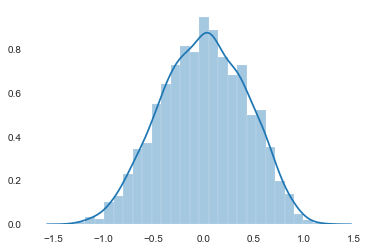

In [418]:
sns.distplot(lm_2.resid)
plt.show()

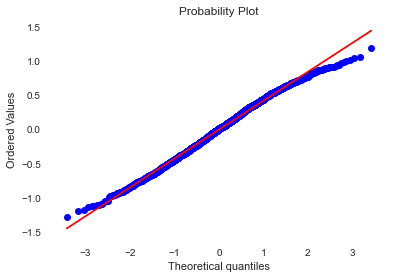

In [419]:
from scipy import stats
import pylab

stats.probplot(lm_2.resid, dist = 'norm', plot = pylab)
pylab.show()

In [421]:
print(stats.stats.pearsonr(lm_2.resid, train.ln_total_spent))

(0.7628390306872826, 0.0)
